# Value Estimation

James Yu, 30 November 2021 modified by mike to use db

## VERSION: $n$, $m$ fixed, ratios endogenous

In [1]:
INSTALL_PACKAGES = false   # change this to true if you are running this notebook for the first time
YEAR_INTERVAL = 2018:2019  # change this to select the years of data to include in the estimation
NUMBER_OF_TYPES = 4        # change this to select the number of types to classify academic departments into
NUMBER_OF_SINKS = 1        # change this to 4 to use individual sink types
NUMBER_OF_ROWS = NUMBER_OF_TYPES + NUMBER_OF_SINKS
TOTAL_DISTRIBUTIONS = NUMBER_OF_ROWS
# change this the index is the type as saved by the categorization progam, the value is the tier that type represents
# at the time of writing this has to be set manually using the dict o in the type allocation notebook
# this version 2021-12-22
type_to_tier = Dict("1" => "3","2" =>"2","3"=>"1","4"=>"4","5"=>"5")

Dict{String, String} with 5 entries:
  "4" => "4"
  "1" => "3"
  "5" => "5"
  "2" => "2"
  "3" => "1"

In [2]:
import Pkg
for package in ["BlackBoxOptim", "Distributions", "ForwardDiff", "JSON", "Optim", "Quadrature", "StatsPlots",
    "DotEnv","MySQL","DBInterface","Tables","HTTP", "JSON"]
    if INSTALL_PACKAGES
        Pkg.add(package)
    end
end
using BlackBoxOptim, Distributions, ForwardDiff, JSON, Optim, Quadrature, StatsPlots, DotEnv, MySQL, DBInterface, Tables, HTTP, JSON

The data in this notebook comes from [https://support.microeconomics.ca/api/placement_data](https://support.microeconomics.ca). The type allocation that is used is the one given by [https://support.econjobmarket.org/api/academic_tiers](https://support.econjobmarket.org/api/academic_tiers)

In [3]:
url = "https://support.econjobmarket.org/api/placement_data";
function get_data(url)
    resp = HTTP.get(url);
    es = String(resp.body)
    return placements = JSON.parse(es)
end
#Reads the data from HTTP URL
placements = get_data(url);
placements = unique(placements);
println(length(placements))

9824


The next step is to fetch the ranking data

In [4]:
url = "https://support.econjobmarket.org/api/academic_tiers"
types = get_data(url);


In [5]:
types[1]

Dict{String, Any} with 5 entries:
  "shortname"      => "Mathematics, University of Oslo"
  "oid"            => "3810"
  "name"           => "University of Oslo"
  "institution_id" => "578"
  "type"           => "1"

Now we can create the adjacency matrix from the placement data using the type allocation in types  Each institution is associated with many organizations.  Organizations can have multiple type assignments if their placements have different postypes.  This function collects all the types that are assigned to an oid

In [6]:
    function recruiter_types(oid, types)
        all_types = Set{String}()
        for t in types
            if t["oid"] == oid
                push!(all_types, t["type"])
            end
        end
        return all_types
    end

recruiter_types (generic function with 1 method)

In [7]:
# extract the tiers of the from_oid and to_oid
# type_to tier is the dict that specifies which tier to use for each type
# type_to_tier is set at the beginning of this notebook
function get_tiers(placement, type_to_tier, types)
    from_tier = false
    from_oid = String
    to_tier = false
    to_oid = String
    for t in types
        if t["oid"] == placement["from_oid"]
                #from_tier= type_to_tier[string(minimum(recruiter_types(t["oid"], types)))]
            from_tier = type_to_tier[minimum(recruiter_types(t["oid"], types))]
            from_oid = t["oid"]
        end
        if t["oid"] == placement["to_oid"]
            if placement["postype"] == "1"
                to_tier = type_to_tier[minimum(recruiter_types(t["oid"], types))]
            else
                to_tier = type_to_tier[maximum(recruiter_types(t["oid"], types))]
            end
            to_oid = t["oid"]
        end
    end
    return from_tier, to_tier
end      
    

get_tiers (generic function with 1 method)

In [10]:
placement_rates = zeros(Int64, (NUMBER_OF_ROWS, NUMBER_OF_TYPES))


5×4 Matrix{Int64}:
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0

In [12]:
n = 1
for p in placements
    if !in(parse(Int64,p["year"]), YEAR_INTERVAL)
        continue
    end

    from_type,  to_type = get_tiers(p, type_to_tier, types)
    if from_type == false
        println("Warning from_type is missing from ", n, " where from id is ", p["from_oid"])
        println(p)
        continue
    end
    if to_type == false
        println("Warning to_type is missing from  ", n, " where to_oid is " , p["to_oid"])
        println(p)
        continue
    end
    #println(parse(Int64,to_type)," ", parse(Int64, from_type))
    #println(placement_rates[parse(Int64,to_type), parse(Int64, from_type)]," ",n)
    placement_rates[parse(Int64,to_type), parse(Int64, from_type)] += 1
    n += 1
end
#for i in 1:TOTAL_DISTRIBUTIONS, j in 1:NUMBER_OF_TYPES
#    placement_rates[order[i], order[j]] = est_mat[i, j]
#end
println(placement_rates)

[125 20 16 0; 102 70 31 3; 186 200 130 11; 15 42 25 18; 401 398 366 127]


In [14]:
placement_rates

5×4 Matrix{Int64}:
 125   20   16    0
 102   70   31    3
 186  200  130   11
  15   42   25   18
 401  398  366  127

In [15]:
sum(placement_rates)

2286

To verify that this is ordered properly, we can check symmetric indices:

In [16]:
for i in 1:NUMBER_OF_TYPES, j in 1:NUMBER_OF_TYPES
    if i > j # not a diagonal and only check once
        if placement_rates[i, j] <= placement_rates[j, i]
            println("FAULT: hiring ", i, " with graduating ", j, ": downward rate: ", placement_rates[i, j], ", upward rate: ", placement_rates[j, i])
        end
    end
end
println("Check Complete")

Check Complete


If everything worked fine, there should be no faults in this cell. If there are, change the order in the cell with the explicit order.

Next, we construct a numerical global minimizer for the chi-squared metric of differences between the above placement rates and a set of theoretically-predicted rates given by values $v_i$ and offer distributions $F_i(x)$. 

We start by constructing the equations which give the theoretical probabilities. Each uses the same notation and indices as in the theory. For $F_i(x)$, we use the two-parameter truncated normal distribution with support on $[0, 1]$.

In [17]:
# define p_vec as
# [v2/v1 v3/v2 v4/v3 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]
# let T = 4
# let S = 1
# then p_vec[i + T - 1] = p_vec[i + 3] for i:1..5 gives mu
# then p_vec[i + T - 1 + T + S] = p_vec[i + 3 + 5] for i:1..5 gives sigma
# then p_vec[i] for i:1..3 gives vi/vj

# truncated normal: https://juliastats.org/Distributions.jl/stable/truncate/#Distributions.TruncatedNormal

function pi_t_(pi_t_minus_1, v_ratio_t, m_t_minus_1, m_t, n)
    return pi_t_minus_1 / (pi_t_minus_1 + ((v_ratio_t ^ (1 / (n - 1))) * m_t_minus_1 / m_t))
end

function F_x_t_(Fx_t_minus_1, pi_t, m_t, v_ratio_t, n)
    return Fx_t_minus_1 - ((m_t / pi_t) * (1 - (v_ratio_t ^ (1 / (n - 1)))))
end

function f_i_x_t_(x, p_vec, i, T, S)
    return pdf(TruncatedNormal(p_vec[i + T - 1], p_vec[i + T - 1 + T + S], 0, 1), x)
end

function F_(x, p_vec, n_vec, n, T, S)
    return sum([(n_vec[i] / n) * cdf(TruncatedNormal(p_vec[i + T - 1], p_vec[i + T - 1 + T + S], 0, 1), x) for i in 1:T+S])
end

function Q_ts_(Fx, Fx_vec, pi_vec, m_vec, n, t, s)
    # pi_vec = [1, pi2, pi3, ...]
    # Fx_vec = [1, Fx1, Fx2, ...]
    # Fx_vec[s] = F(x_{s-1})
    target = ((Fx_vec[s] - Fx) * pi_vec[t] * prod([(1.0 - pi_vec[i]) for i in t+1:s]) / m_vec[t]) 
    subtractor = sum([(Fx_vec[k] - Fx_vec[k + 1]) * pi_vec[t] * prod([(1.0 - pi_vec[i]) for i in t+1:k]) / m_vec[t] for k in t:s-1])
    return (1.0 - target - subtractor) ^ (n - 1.0)
end

# numerical integration docs: https://juliapackages.com/p/quadrature
function h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
    # x_vec = [x0, x1, x2, ...]
    # x_vec[s] = x_{s-1}
    return sum([pi_vec[t] * prod([(1.0 - pi_vec[j]) for j in t+1:s]) * solve(QuadratureProblem((x, p) -> Q_ts_(F_(x, p, n_vec, n, T, S), Fx_vec, pi_vec, m_vec, n, t, s) * f_i_x_t_(x, p, i, T, S), x_vec[s + 1], x_vec[s], p_vec), HCubatureJL())[1] for s in t:T])
end

h_it_ (generic function with 1 method)

Finally, the chi-square estimator is constructed using the theoretical equations and the observed data.

In [18]:
# at one point this method was based on 
# https://discourse.julialang.org/t/a-hacky-guide-to-using-automatic-differentiation-in-nested-optimization-problems/39123
# though has since evolved to not use autodifferentiation in the outer optimizer, which turns out to be faster

# optimization reference: https://julianlsolvers.github.io/Optim.jl/stable/#user/minimization/
# this reference also references the global minimizer used for the outer optimizer: 
# https://github.com/robertfeldt/BlackBoxOptim.jl
function chisquare(p_vec, T, S, placements, years, start_n, start_m)
    n_vec = p_vec[start_n:start_n+T+S-1]
    m_vec = p_vec[start_m:start_m+T-1]
    n = 1550
    m = 1700
    n_vec = n * n_vec / sum(n_vec)
    m_vec = m * m_vec / sum(m_vec)
    pi_vec = ones(T)
    Fx_vec = ones(T)
    for t in 2:T
        pi_vec[t] = pi_t_(pi_vec[t - 1], p_vec[t - 1], m_vec[t - 1], m_vec[t], n) 
        # note pi_vec = [pi1 = 1, pi2, pi3, pi4] but Fx_vec = [Fx0 = 1, Fx1, Fx2, Fx3] 
        Fx_vec[t] = F_x_t_(Fx_vec[t - 1], pi_vec[t - 1], m_vec[t - 1], p_vec[t - 1], n)
    end
    
    x_vec = ones(T + 1) # x_vec = [x0 = 1, x1, x2, x3, x4 = 0]
    x_vec[T + 1] = 0.0
    for i in 1:T-1
        packet = optimize(x -> (F_(x[1], p_vec, n_vec, n, T, S) - (Fx_vec[i] - ((m_vec[i] / pi_vec[i]) * (1.0 - (p_vec[i] ^ (1.0 / (n - 1.0))))))) ^ 2, [0.0], [1.0], [0.5], Fminbox(LBFGS()); autodiff = :forward)
        x_vec[i + 1] = Optim.minimizer(packet)[1] # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
    end
    
    objective = 0.0
    for i in 1:size(placements)[1], t in 1:size(placements)[2]
        mean = n_vec[i] * years * h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
        objective += (placements[i, t] - mean) ^ 2 / mean
    end
    
    return objective
end

# upper bound on the value ratios, which should all be less than 1
# if any ratio turns out to be 1.0 or close to it at optimality, this could indicate that a lower tier has a higher value than a higher one
upper = [1.0 for i in 1:NUMBER_OF_TYPES-1] 

# upper bound on the mu parameter of truncated normal, which is strictly within [0, 1] as the mean is greater than mu in truncated normal
append!(upper, [1.0 for i in 1:NUMBER_OF_ROWS])

# reasonable upper bound on the sigma parameter of truncated normal
# if any parameter estimate is close to this at optimality, make the upper bound higher
append!(upper, [10.0 for i in 1:NUMBER_OF_ROWS])

# n_i
start_n = length(upper) + 1
append!(upper, [2000.0 for i in 1:NUMBER_OF_TYPES+NUMBER_OF_SINKS])

# m_i
start_m = length(upper) + 1
append!(upper, [2000.0 for i in 1:NUMBER_OF_TYPES])

# all lower bounds are zero as these should be positive parameters
res = bboptimize(p -> chisquare(p, NUMBER_OF_TYPES, NUMBER_OF_SINKS, placement_rates, Float64(length(YEAR_INTERVAL)), start_n, start_m), SearchRange = [(0.0, upper[i]) for i in 1:length(upper)], MaxFuncEvals = 100000, TraceInterval = 10)
sol = best_candidate(res)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 5013 evals, 4925 steps, improv/step: 0.221 (last = 0.2207), fitness=180.052960874
20.03 secs, 9188 evals, 9096 steps, improv/step: 0.178 (last = 0.1266), fitness=86.262796977
30.03 secs, 12530 evals, 12419 steps, improv/step: 0.166 (last = 0.1360), fitness=75.367308450
40.03 secs, 15190 evals, 15071 steps, improv/step: 0.161 (last = 0.1380), fitness=63.480022266
50.03 secs, 17983 evals, 17860 steps, improv/step: 0.158 (last = 0.1420), fitness=56.430334858
60.04 secs, 20838 evals, 20715 steps, improv/step: 0.156 (last = 0.1405), fitness=54.236644334
70.04 secs, 23616 evals, 23493 steps, improv/step: 0.151 (last = 0.1177), fitness=53.629130845
80.04 secs, 26497 evals, 26374 steps, improv/step: 0.150 (last = 0.1381), fitness=53.390267941
90.04 secs, 29335 evals, 29212 steps, i

22-element Vector{Float64}:
    0.7442751870387673
    0.9080218570032345
    0.8440692962894609
    0.5885796800329717
    0.5143874140822092
    0.48814504892464994
    0.06867379500401215
    0.03301045458464233
    0.12422406717207865
    0.051595182112537843
    0.04187682464494525
    0.014310708947576297
    0.2745150508337838
  171.29613820998705
  232.06476488812206
  607.7955697702158
  203.21593480854534
 1983.0107669225051
 1809.7887643958557
 1888.6193498019718
 1586.509909510406
  531.5155986203827

Given the estimate for the global minimum, we can print out some summary metrics:

In [20]:
function print_metrics(p_vec, m_vec, n_vec, n, T, S, placements, years)
    n = 1550
    m = 1700
    n_vec = n * n_vec / sum(n_vec)
    m_vec = m * m_vec / sum(m_vec)
    pi_vec = ones(T)
    Fx_vec = ones(T)
    for t in 2:T
        pi_vec[t] = pi_t_(pi_vec[t - 1], p_vec[t - 1], m_vec[t - 1], m_vec[t], n) 
        # note pi_vec = [pi1 = 1, pi2, pi3, pi4] but Fx_vec = [Fx0 = 1, Fx1, Fx2, Fx3] 
        Fx_vec[t] = F_x_t_(Fx_vec[t - 1], pi_vec[t - 1], m_vec[t - 1], p_vec[t - 1], n)
    end
    
    x_vec = ones(T + 1) # x_vec = [x0 = 1, x1, x2, x3, x4 = 0]
    x_vec[T + 1] = 0.0
    min_vec = zeros(T + 1)
    for i in 1:T-1
        packet = optimize(x -> (F_(x[1], p_vec, n_vec, n, T, S) - (Fx_vec[i] - ((m_vec[i] / pi_vec[i]) * (1.0 - (p_vec[i] ^ (1.0 / (n - 1.0))))))) ^ 2, [0.0], [1.0], [0.5], Fminbox(LBFGS()); autodiff = :forward)
        x_vec[i + 1] = Optim.minimizer(packet)[1] # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        min_vec[i + 1] = Optim.minimum(packet)[1]
    end
    
    objective = 0.0
    q_matrix = zeros((T, T))
    h_matrix = zeros(size(placements))
    nh_matrix = zeros(size(placements))
    for i in 1:size(placements)[1], t in 1:size(placements)[2]
        h_for_matrix = h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
        mean = n_vec[i] * years * h_for_matrix
        h_matrix[i, t] = h_for_matrix
        nh_matrix[i, t] = mean
        objective += (placements[i, t] - mean) ^ 2 / mean
    end
    
    for s in 1:T, t in 1:T
        q_for_matrix = Q_ts_(F_(x_vec[s], p_vec, n_vec, n, T, S), Fx_vec, pi_vec, m_vec, n, t, s)
        q_matrix[s, t] = q_for_matrix
    end

    for i in 1:T
        println("pi_", i, " = ", pi_vec[i])
    end
    println()
    for i in 1:T+1
        println("x_", i - 1, " = ", x_vec[i], " (error: ", min_vec[i], ")")
    end
    println()
    for i in 1:T
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    println("objective value = ", objective)
    println()
    println("estimated n_i = ", round.(n_vec))
    println("estimated m_i = ", round.(m_vec))
    println()
    println("estimated Q_t(x_s) (rows are offer value from high to low, columns are type in increasing type index:")
    for i in 1:size(q_matrix)[1]
        println(round.(q_matrix[i, :], digits = 4))
    end
    println()
    println("estimated h_it:")
    for i in 1:size(h_matrix)[1]
        println(round.(h_matrix[i, :], digits = 4))
    end
    println()
    println("estimated placement rates:")
    for i in 1:size(nh_matrix)[1]
        println(round.(nh_matrix[i, :], digits = 4))
    end
    println()
    println("actual placement rates:")
    for i in 1:size(placement_rates)[1]
        println(placement_rates[i, :])
    end
    println()
    println("difference between estimated and actual placement rates:")
    for i in 1:size(placement_rates)[1]
        println(round.(nh_matrix[i, :] - placement_rates[i, :], digits = 4))
    end
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placement_rates)[1] - 1) * (size(placement_rates)[2] - 1)), objective))
end

n_vec = sol[start_n:start_n+NUMBER_OF_ROWS-1]
m_vec = sol[start_m:start_m+NUMBER_OF_TYPES-1]
n = sum(n_vec)
print_metrics(sol, m_vec, n_vec, n, NUMBER_OF_TYPES, NUMBER_OF_SINKS, placement_rates, Float64(length(YEAR_INTERVAL)))

pi_1 = 1.0
pi_2 = 0.4860499804501174
pi_3 = 0.2838688983807772
pi_4 = 0.09679385198397915

x_0 = 1.0 (error: 0.0)
x_1 = 0.23583039275571727 (error: 1.072468362222402e-17)
x_2 = 0.16876557147942683 (error: 6.812200501687264e-19)
x_3 = 0.0663033127532454 (error: 2.9888853042927195e-24)
x_4 = 0.0 (error: 0.0)

F(x_0) = 1.0
F(x_1) = 0.9553455924522081
F(x_2) = 0.9052782777270049
F(x_3) = 0.608258023584878

objective value = 54.37258120784341

estimated n_i = [82.0, 109.0, 295.0, 106.0, 959.0]
estimated m_i = [565.0, 534.0, 436.0, 165.0]

estimated Q_t(x_s) (rows are offer value from high to low, columns are type in increasing type index:
[1.0, 1.0, 1.0, 1.0]
[0.8848, 1.0, 1.0, 1.0]
[0.8245, 0.9319, 1.0, 1.0]
[0.611, 0.6906, 0.7411, 1.0]

estimated h_it:
[0.6705, 0.1291, 0.0661, 0.0094]
[0.412, 0.2743, 0.1334, 0.0107]
[0.282, 0.2893, 0.1976, 0.0163]
[0.1272, 0.136, 0.119, 0.0606]
[0.178, 0.1903, 0.1665, 0.0594]

estimated placement rates:
[109.4858, 21.0814, 10.7922, 1.5291]
[89.8, 59.7984,

The estimated value ratios:

In [21]:
for i in 1:NUMBER_OF_TYPES-1
    println("v_", i + 1, "/v_", i, " = ", sol[i])
end

v_2/v_1 = 0.8848032977086637
v_3/v_2 = 0.931898318535847
v_4/v_3 = 0.74105430092373


If we let $v_1 = 1$, then we get:

In [23]:
v_base = 1
for i in 1:NUMBER_OF_TYPES
    println("v", i, ": ", v_base)
    if i != NUMBER_OF_TYPES
        v_base = sol[i] * v_base
    end
end

v1: 1
v2: 0.8848032977086637
v3: 0.8245467053696762
v4: 0.6110338823266902


In [24]:
for select_type in 1:NUMBER_OF_TYPES
    println("mean for type ", select_type, ": ", mean(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1)))
    println("stddev for type ", select_type, ": ", std(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1)))
    println()
end
println("mean for sink: ", mean(TruncatedNormal(sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS], sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS+TOTAL_DISTRIBUTIONS], 0, 1)))
println("stddev for sink: ", std(TruncatedNormal(sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS], sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS+TOTAL_DISTRIBUTIONS], 0, 1)))

mean for type 1: 0.3270040511656989
stddev for type 1: 0.23415847071505486

mean for type 2: 0.1574397125124894
stddev for type 2: 0.080223909692066

mean for type 3: 0.11251194982418182
stddev for type 3: 0.05271122156967269

mean for type 4: 0.00988581417350142
stddev for type 4: 0.005157136563499312

mean for sink: 0.04508595172865681
stddev for sink: 0.026903702596868254


Finally, we can plot the CDFs and PDFs of the distributions:

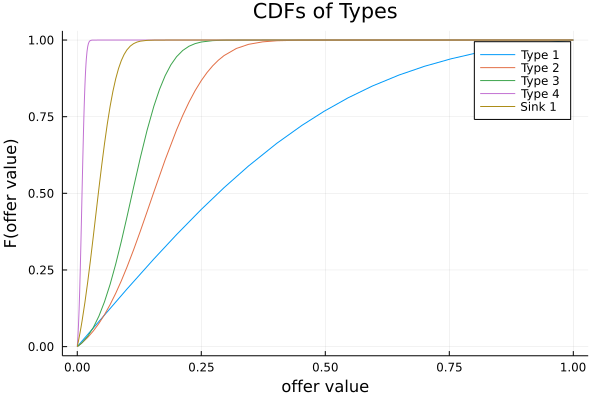

In [25]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/

select_type = 1
cdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(cdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, label = string("Type ", select_type))
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    plot!(cdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
end
xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
cdfs

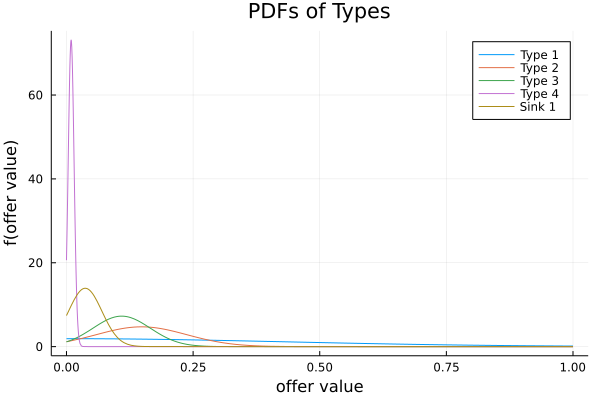

In [26]:
select_type = 1
pdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Type ", select_type))
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
pdfs

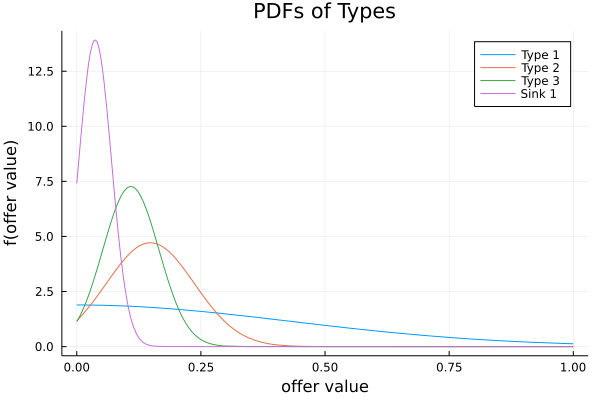

In [27]:
TYPE_TO_DELETE = 4 # change this if you want to remove the pdf of a different academic type; set to zero to not delete any
SINK_TO_DELETE = 0 # change this if you want to remove the pdf of a different sink type

select_type = 1
pdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    if select_type != TYPE_TO_DELETE
        plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Type ", select_type))
    end
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    if select_type != SINK_TO_DELETE + NUMBER_OF_TYPES
        plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
    end
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
pdfs

The actual allocation of departments to types is:

## References

Karrer, B., and M. E. J. Newman (2011): "Stochastic Blockmodels and community structure in networks," Physical Review, 83(1).

Peixoto, T. (2014): "Efficient Monte Carlo and greedy heuristic for the inference of stochastic block models," Physical Review, 89(1).